In [1]:
import requests
import lxml.html as lh
import pandas as pd

In [2]:
page_sonic = requests.get('https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/')
page_inception = requests.get('https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/')
print(page_sonic)
doc_sonic = lh.fromstring(page_sonic.content)
doc_inception = lh.fromstring(page_inception.content)
url_page="?page="
nb_pages_sonic=5
nb_pages_inception=477

<Response [200]>


## Scrappingf pour Sonic 2

In [4]:
notes = []
coms = []
appreciation = []

for i in range(nb_pages_sonic):
    page_sonic = requests.get('https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/'+url_page+str(i))
    doc_sonic = lh.fromstring(page_sonic.content)
    com_film=doc_sonic.xpath('//div[@class="content-txt review-card-content"]')
    note_film=doc_sonic.xpath('//span[@class="stareval-note"]')

    for i in range(len(com_film)):
        notes.append(note_film[i].text_content().strip())
        coms.append(com_film[i].text_content().strip())

for i in notes :
    u = i.replace(",", ".")
    if float(u) > 3 :
        appreciation.append(1)
    else :
        appreciation.append(0)

sonic_df = pd.DataFrame(list(zip(coms, notes, appreciation)),
                columns =['commentaire', 'note', 'appreciation'])

print(sonic_df.shape)

(75, 3)


## Scrapping pour inception

In [6]:
notes = []
coms = []
appreciation = []

for i in range(nb_pages_inception):
    page_inception = requests.get('https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/'+url_page+str(i))
    doc_inception = lh.fromstring(page_inception.content)
    com_film=doc_inception.xpath('//div[@class="content-txt review-card-content"]')
    note_film=doc_inception.xpath('//span[@class="stareval-note"]')

    for i in range(len(com_film)):
        notes.append(note_film[i].text_content().strip())
        coms.append(com_film[i].text_content().strip())

for i in notes :
    i = i.replace(",", ".")
    if float(i) > 3 :
        appreciation.append(1)
    else :
        appreciation.append(0)
c=0            
for i in appreciation :
    if i == 0 :
        c+=1
print(c)
inception_df = pd.DataFrame(list(zip(coms, notes, appreciation)),
                columns =['commentaire', 'note', 'appreciation'])



1379


In [8]:
import csv
import re
REMPLACE_SANS_ESPACE = re.compile("[;:!\'?,\"()\[\]]")
REMPLACE_AVEC_ESPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|[.]")

def preprocess(txt):
    txt = [line.replace('\n', ' ')  for line in txt] # Retire les \n (retours chariots)
    txt = [REMPLACE_SANS_ESPACE.sub("", line.lower()) for line in txt]
    txt = [REMPLACE_AVEC_ESPACE.sub(" ", line) for line in txt]
    return txt
inception_df['commentaire'] = pd.DataFrame(preprocess(inception_df['commentaire']))
sonic_df['commentaire'] = pd.DataFrame(preprocess(sonic_df['commentaire']))

In [9]:
inception_df.to_csv('allocine_inception_avis.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
sonic_df.to_csv('allocine_sonic_avis.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [10]:
pd.read_csv('allocine_inception_avis.csv')

,commentaire,note,appreciation
0,après le chef doeuvre super héroïque the dark ...,"5,0",1
1,c’est fou ce qu’on aime détester christopher n...,"5,0",1
2,chef d’œuvre le film est absolument parfait ...,"5,0",1
3,un film aussi novateur que complexe dont la mi...,"5,0",1
4,le meilleur blockbuster de 2010 a pour thème l...,"3,5",1
...,...,...,...
7150,super film un scénario vraiment original les ...,"5,0",1
7151,très très bien une histoire a ce tordre lesp...,"5,0",1
7152,je suis decu de voir quune fois de plus le sno...,"0,5",0
7153,se film est tout simplement merveilleux je sui...,"5,0",1


In [11]:
pd.read_csv('allocine_sonic_avis.csv')

,commentaire,note,appreciation
0,cette suite de sonic est incroyable le fan que...,"5,0",1
1,une bonne suite pour les aventures de sonic au...,"4,0",1
2,malgré deux nouveaux personnages de lunivers d...,"3,0",0
3,très bon film ont retrouve ce qui fait l’espri...,"4,0",1
4,super film de ouf le fait que knuckles soit du...,"4,0",1
...,...,...,...
70,dans la droite lignée du premier avec évidemme...,"3,5",1
71,jim carrey excellent les enfants ont adoré jai...,"4,0",1
72,un excellent divertissement avec des personnag...,"3,5",1
73,ce film est trop cool🤩🤩🤩 les scènes de combat ...,"5,0",1


In [12]:
films_df = pd.concat([inception_df,sonic_df], ignore_index=True)

In [13]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [14]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import FrenchStemmer

french_stopwords = set(stopwords.words('french'))
filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]
films_df['commentaire'] = [' '.join(filtre_stopfr(word_tokenize(item))) for item in films_df['commentaire']]


stemmer = FrenchStemmer()
films_df['commentaire'] = [stemmer.stem(w) for w in films_df['commentaire']]



In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(films_df['commentaire'], films_df['appreciation'], test_size=0.2, random_state=42)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(binary=True)
cv.fit(X_train)
 
X_train_onehot = cv.transform(X_train)
X_test_onehot = cv.transform(X_test)
pd.DataFrame(X_test_onehot.toarray())

,0,1,2,3,4,5,6,7,8,9,...,20916,20917,20918,20919,20920,20921,20922,20923,20924,20925
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1442,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
print(X_test_onehot.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train_onehot, y_train)
    print ("Précision pour C=%s: %s" % (c, accuracy_score(y_test, lr.predict(X_test_onehot))))


Précision pour C=0.01: 0.8554633471645919
Précision pour C=0.05: 0.9024896265560166
Précision pour C=0.25: 0.9114799446749654
Précision pour C=0.5: 0.9107883817427386
Précision pour C=1: 0.9128630705394191


In [19]:
modele_final = LogisticRegression(C=0.5)
modele_final.fit(X_train_onehot, y_train)


print ("Précision: %s" % accuracy_score(y_test, modele_final.predict(X_test_onehot)))

Précision: 0.9107883817427386


[1]


<AxesSubplot:>

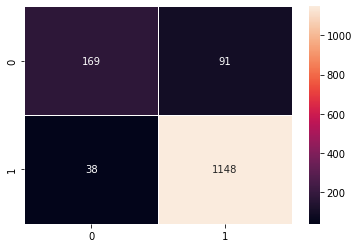

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = modele_final.predict(X_test_onehot)
y_p=modele_final.predict(X_test_onehot[0])
print(y_p)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')

## Live test

In [21]:
def prediction(commentaire):   
    d = {'com': commentaire}
    df_com = pd.DataFrame(data= d, index=[0])

    french_stopwords = set(stopwords.words('french'))
    filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]
    df_com['com'] = [' '.join(filtre_stopfr(word_tokenize(item))) for item in df_com['com']]


    stemmer = FrenchStemmer()
    df_com['com'] = [stemmer.stem(w) for w in df_com['com']]

    df_com_onehot = cv.transform(df_com)
    pd.DataFrame(df_com_onehot.toarray())
    print(df_com_onehot.toarray(), len(df_com_onehot.toarray()[0]))
    prediction = modele_final.predict(df_com_onehot) 
    print(prediction) 
    return prediction 

In [23]:
commentaire = input("saisissez un commentaire : ")

pred = prediction(commentaire)
if pred == 1 :
    print('avis positif')
else :
    print('avis négatif')

saisissez un commentaire : c'estr nul
[[0 0 0 ... 0 0 0]] 20926
[1]
avis positif


In [23]:
%pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pillow in c:\users\utilisateur\anaconda3\lib\site-packages (from wordcloud) (8.4.0)
  Running setup.py clean for wordcloud
Failed to build wordcloud
    Running setup.py install for wordcloud: started
    Running setup.py install for wordcloud: finished with status 'error'



  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Utilisateur\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Utilisateur\\AppData\\Local\\Temp\\pip-install-eagdnat_\\wordcloud_3ad6fdaad54d428cbbc42599d6a627e2\\setup.py'"'"'; __file__='"'"'C:\\Users\\Utilisateur\\AppData\\Local\\Temp\\pip-install-eagdnat_\\wordcloud_3ad6fdaad54d428cbbc42599d6a627e2\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Utilisateur\AppData\Local\Temp\pip-wheel-vu46id6h'
       cwd: C:\Users\Utilisateur\AppData\Local\Temp\pip-install-eagdnat_\wordcloud_3ad6fdaad54d428cbbc42599d6a627e2\
  Complete output (20 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  cr

In [24]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
SW = stopwords.words('french')
WC=WordCloud(background_color = 'white',stopwords = SW,max_words = 4).generate(films_df['commentaire'])
plt.imshow(WC)
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'wordcloud'